In [1]:
library(DESeq2)
library(RColorBrewer)
library(reshape2)
library("gplots")
library("GGally")                      # Load GGally package
library(goseq)
library(readxl)
library(tidyverse)
library("pheatmap")
library(corrplot)
library(circlize)

Warning message:
"package 'DESeq2' was built under R version 4.2.2"
Loading required package: S4Vectors

Warning message:
"package 'S4Vectors' was built under R version 4.2.2"
Loading required package: stats4

Loading required package: BiocGenerics

Warning message:
"package 'BiocGenerics' was built under R version 4.2.1"

Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: 'S4Vectors'


The following objects are masked from 'package:base':

    exp

In [2]:
library(ComplexUpset)

Warning message:
"package 'ComplexUpset' was built under R version 4.2.2"


In [3]:
library(ggrepel)

Warning message:
"package 'ggrepel' was built under R version 4.2.1"


In [4]:
library(ComplexHeatmap)

Warning message:
"package 'ComplexHeatmap' was built under R version 4.2.1"
Loading required package: grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))
! pheatmap() has been masked by ComplexHeatmap::pheatmap(). Most of the arguments
   in the original pheatmap() are identically supported in the new function. You 
   can still use the original fu

In [5]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)

In [82]:
fname_hcounts = file.path('..', 'RNASEQ', 'data', 'MED4_counts_combined.txt')
hcdf = read.csv(fname_hcounts, sep='\t' )
hgenes = hcdf[,c(1,2,3,4,5)]
hpath_fname = file.path('..', 'genomes', 'MED4', 'MED4_pathways.csv')
hpath_df = read.csv(hpath_fname)
hpath_df = left_join(hgenes, hpath_df, by='protein_id')

Warning message in left_join(hgenes, hpath_df, by = "protein_id"):
"Each row in `x` is expected to match at most 1 row in `y`.
ℹ Row 1 of `x` matches multiple rows.
ℹ If multiple matches are expected, set `multiple = "all"` to silence this warning."


In [83]:
bpath_fname = file.path('..', 'genomes', 'MED4', 'MED4_biocyc_pathways.txt')
bpath_df = read.csv(bpath_fname, sep='\t')

In [84]:
bpath_df = bpath_df %>% rename(gene_id = Accession.2) %>% 
    separate_longer_delim(Pathways.of.gene, delim  = ' // ') %>%
    separate_longer_delim(Ontology...pathway.type, delim  = ' // ')


In [85]:
tail(bpath_df)

,Gene.Name,Accession.1,Product,gene_id,Pathways.of.gene,Ontology...pathway.type
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
4223,purN,PMM0891,phosphoribosylglycinamide formyltransferase,TX50_RS04760,"tetrahydrofolate salvage from 5,10-methenyltetrahydrofolate","Cofactor, Carrier, and Vitamin Biosynthesis"
4224,purN,PMM0891,phosphoribosylglycinamide formyltransferase,TX50_RS04760,"tetrahydrofolate salvage from 5,10-methenyltetrahydrofolate",Nucleoside and Nucleotide Biosynthesis
4225,purN,PMM0891,phosphoribosylglycinamide formyltransferase,TX50_RS04760,5-aminoimidazole ribonucleotide biosynthesis I,Superpathways
4226,purN,PMM0891,phosphoribosylglycinamide formyltransferase,TX50_RS04760,5-aminoimidazole ribonucleotide biosynthesis I,"Cofactor, Carrier, and Vitamin Biosynthesis"
4227,purN,PMM0891,phosphoribosylglycinamide formyltransferase,TX50_RS04760,5-aminoimidazole ribonucleotide biosynthesis I,Nucleoside and Nucleotide Biosynthesis
4228,mrdA,PMM0040,penicillin-binding protein 2,TX50_RS00215,peptidoglycan maturation (<i>meso</i>-diaminopimelate containing),Cell Structure Biosynthesis


In [86]:
hpath_df = hpath_df  %>% 
    extract(path, c("pathway"), "^[[:digit:]]* *([^\\[]+) *\\[?", remove = FALSE) %>%
    mutate(pathway = str_replace(pathway, "in photosynthetic organisms", "")) %>%
    mutate(pathway = str_trim(pathway))

In [87]:
hpath_df = hpath_df %>% 
    extract(sub, c("module"), "^[[:digit:]]* *([^\\[]+) *\\[?", remove = FALSE) %>%

    mutate(module = str_replace(module, "in photosynthetic organisms", "")) %>%
    mutate(module = str_replace(module, "biosynthesis and metabolism", "")) %>%
    mutate(module = str_replace(module, "metabolism", "")) %>%
    mutate(module = str_replace(module, "Biosynthesis of", "")) %>%
    mutate(module = str_replace(module, "Metabolism of", "")) %>%
    mutate(module = str_replace(module, "biosynthesis", "")) %>%
    mutate(module = str_trim(module)) 



In [202]:
hpath_df = hpath_df %>% 
    mutate(Module1 = case_when(
    module %in% c('Translation', 'Nucleotide') ~ 'Genetic information',
    module %in% c('Carbohydrate','Energy', 'Glycan') ~ 'Energy and Carbohydrate',
    module %in% c('Amino acid', 'other amino acids') ~ 'Amino acid',
    module %in% c('terpenoids and polyketides','other secondary metabolites','cofactors and vitamins') ~ 'Secondary metabolite',
    #module %in% c('Lipid') ~ module,
    #module %in% c('Membrane transport', 'Lipid') ~ module,
    module %in% c('Protein families: signaling and cellular processes', 'Unclassified: signaling and cellular processes') ~ 'Signaling and Cellular',
    module %in% c('Protein families: genetic information processing', 'Unclassified: genetic information processing') ~ 'Genetic information',
     (main %in% c(NA, '', 'NA', '09190 Not Included in Pathway or Brite')) & (gene == '') & 
        (str_detect(product, 'hypothetical') | str_detect(product, 'domain-containing') | 
         str_detect(product, 'family') | (module %in% 'Poorly characterized')
        ) ~ 'Function Unknown',
        
        .default = 'Other'

        ))


In [203]:
dput (unique(hpath_df$Module1
            ))

c("Other", "Genetic information", "Function Unknown", "Amino acid", 
"Signaling and Cellular", "Secondary metabolite", "Energy and Carbohydrate"
)


In [204]:
hpath_df = hpath_df %>% 
    mutate(Module1 = factor(Module1, levels = c(
        "Function Unknown", 
        "Amino acid",
        "Energy and Carbohydrate", 
        "Genetic information", 
        "Signaling and Cellular", 
        "Secondary metabolite", 
        "Other"
    )))

In [205]:
module_df = hpath_df %>% arrange(gene_id, Module1) %>% distinct(gene_id, .keep_all = TRUE, )

In [206]:
hpath_df = hpath_df %>% 
    extract(ecpath, c("kegg_gene"), "^K[[:digit:]]+ *([^;]*);", remove = FALSE) 

In [207]:
hpath_df %>%  count(Module1) %>% arrange(desc(n))

Module1,n
<fct>,<int>
Other,816
Function Unknown,725
Genetic information,522
Energy and Carbohydrate,323
Secondary metabolite,197
Amino acid,180
Signaling and Cellular,163


In [236]:
modulenames = module_df %>%  
    count(Module1) %>% 
    arrange(desc(n)) %>% 
    mutate(percent = round(100 * n/sum(n))) %>%
    mutate(Module = paste0(Module1, ' (',percent, '%)')) %>%
    select(Module1, Module)
    

In [237]:
modulenames

Module1,Module
<fct>,<chr>
Function Unknown,Function Unknown (39%)
Genetic information,Genetic information (18%)
Other,Other (15%)
Energy and Carbohydrate,Energy and Carbohydrate (9%)
Amino acid,Amino acid (7%)
Secondary metabolite,Secondary metabolite (6%)
Signaling and Cellular,Signaling and Cellular (6%)


In [256]:
module_df = left_join(module_df, modulenames)

Joining with `by = join_by(Module1, Module)`


In [257]:
dput(modulenames$Module)

c("Function Unknown (39%)", "Genetic information (18%)", "Other (15%)", 
"Energy and Carbohydrate (9%)", "Amino acid (7%)", "Secondary metabolite (6%)", 
"Signaling and Cellular (6%)")


In [258]:
module_df$Module = factor(module_df$Module, levels = c("Function Unknown (39%)", "Genetic information (18%)", 
"Energy and Carbohydrate (9%)", "Amino acid (7%)", "Secondary metabolite (6%)", 
"Signaling and Cellular (6%)", "Other (15%)")
                         )

# Enrichment of differentially expressed proteins and transcripts

Compare DE genes and DE proteins and run enrichment for all

# Create DE df

In [259]:
df_all = read_csv(file.path('DE_results', 'MED4_all_FC_results.csv'))

Rows: 24377 Columns: 11
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (4): contrast, gene_id, Assay, contrast1
dbl (5): logFC, AveExpr, pvalue, padj, Length
lgl (2): down, up

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [260]:
df_all = left_join(df_all, module_df, by='gene_id')

In [261]:
df_filtered = df_all %>% 
    filter(contrast1 %in% c( 
        #"P2vsP1_rna", 
        #"C2vsC1_rna", 
        "C3vsC1_rna", 
        "C4vsC1_rna", "C5vsC1_rna")
          ) %>% 
    mutate(Day = case_when(
        #contrast1 == "P2vsP1_rna" ~ 'Control', 
        #contrast1 == "C2vsC1_rna" ~ 'Day 11', 
        contrast1 == "C3vsC1_rna" ~ 'Day 30', 
        contrast1 == "C4vsC1_rna" ~ 'Day 60', 
        contrast1 == "C5vsC1_rna" ~ 'Day 90', 
    )) %>%
    mutate(Day = factor(Day, levels = c(#"Control", 
        #"Day 11", 
        "Day 30", "Day 60", "Day 90")))

In [262]:
dput(unique(df_filtered$Day))

structure(1:3, levels = c("Day 30", "Day 60", "Day 90"), class = "factor")


In [263]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)

In [264]:
goseq_pal_up_fun = colorRamp2(c(0,-log10(0.05), 6), c("white", 'pink', "red"))
pupgoseq = goseq_pal_up_fun(seq(0, 6))
goseq_pal_down_fun = colorRamp2(c(0,-log10(0.05), 6), c("white", 'lightblue', "blue"))
pdowngoseq = goseq_pal_down_fun(seq(0, 6))

In [265]:
goseq_pal_updown_fun = colorRamp2(c(-6, log10(0.05), 0,-log10(0.05), 6), c('blue', 'lightblue', "white", 'pink', "red"))


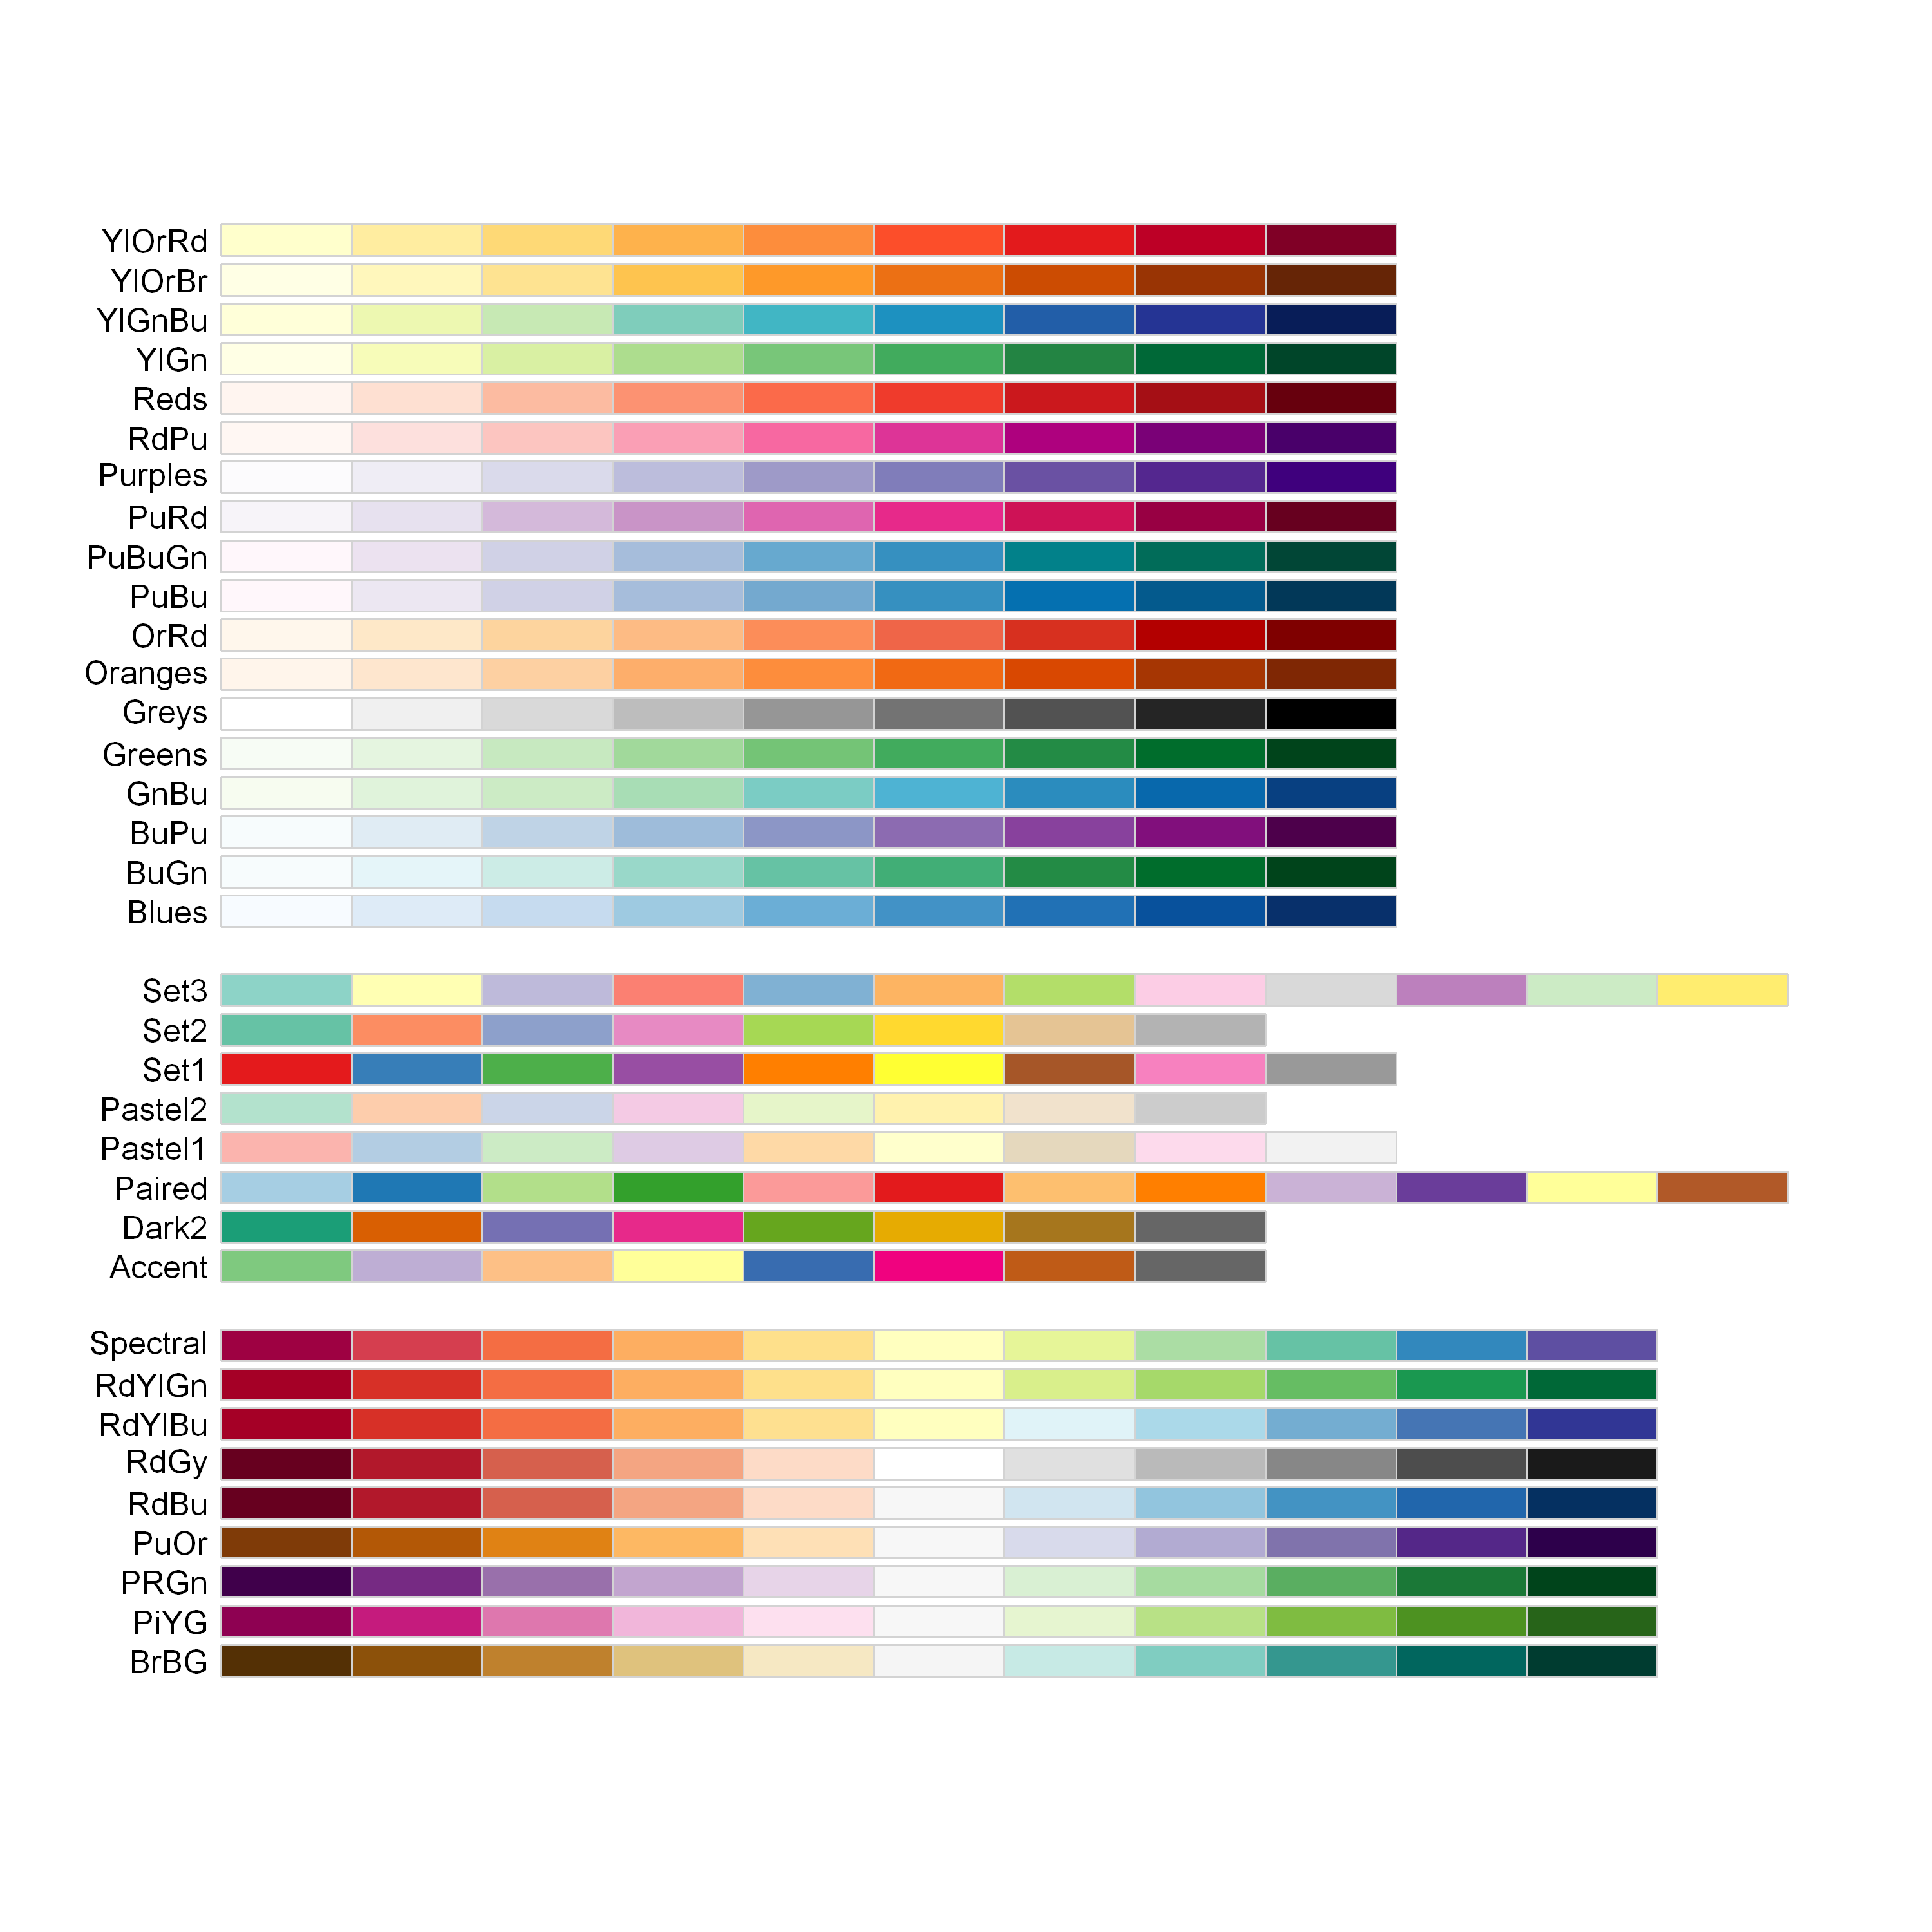

In [266]:
display.brewer.all()

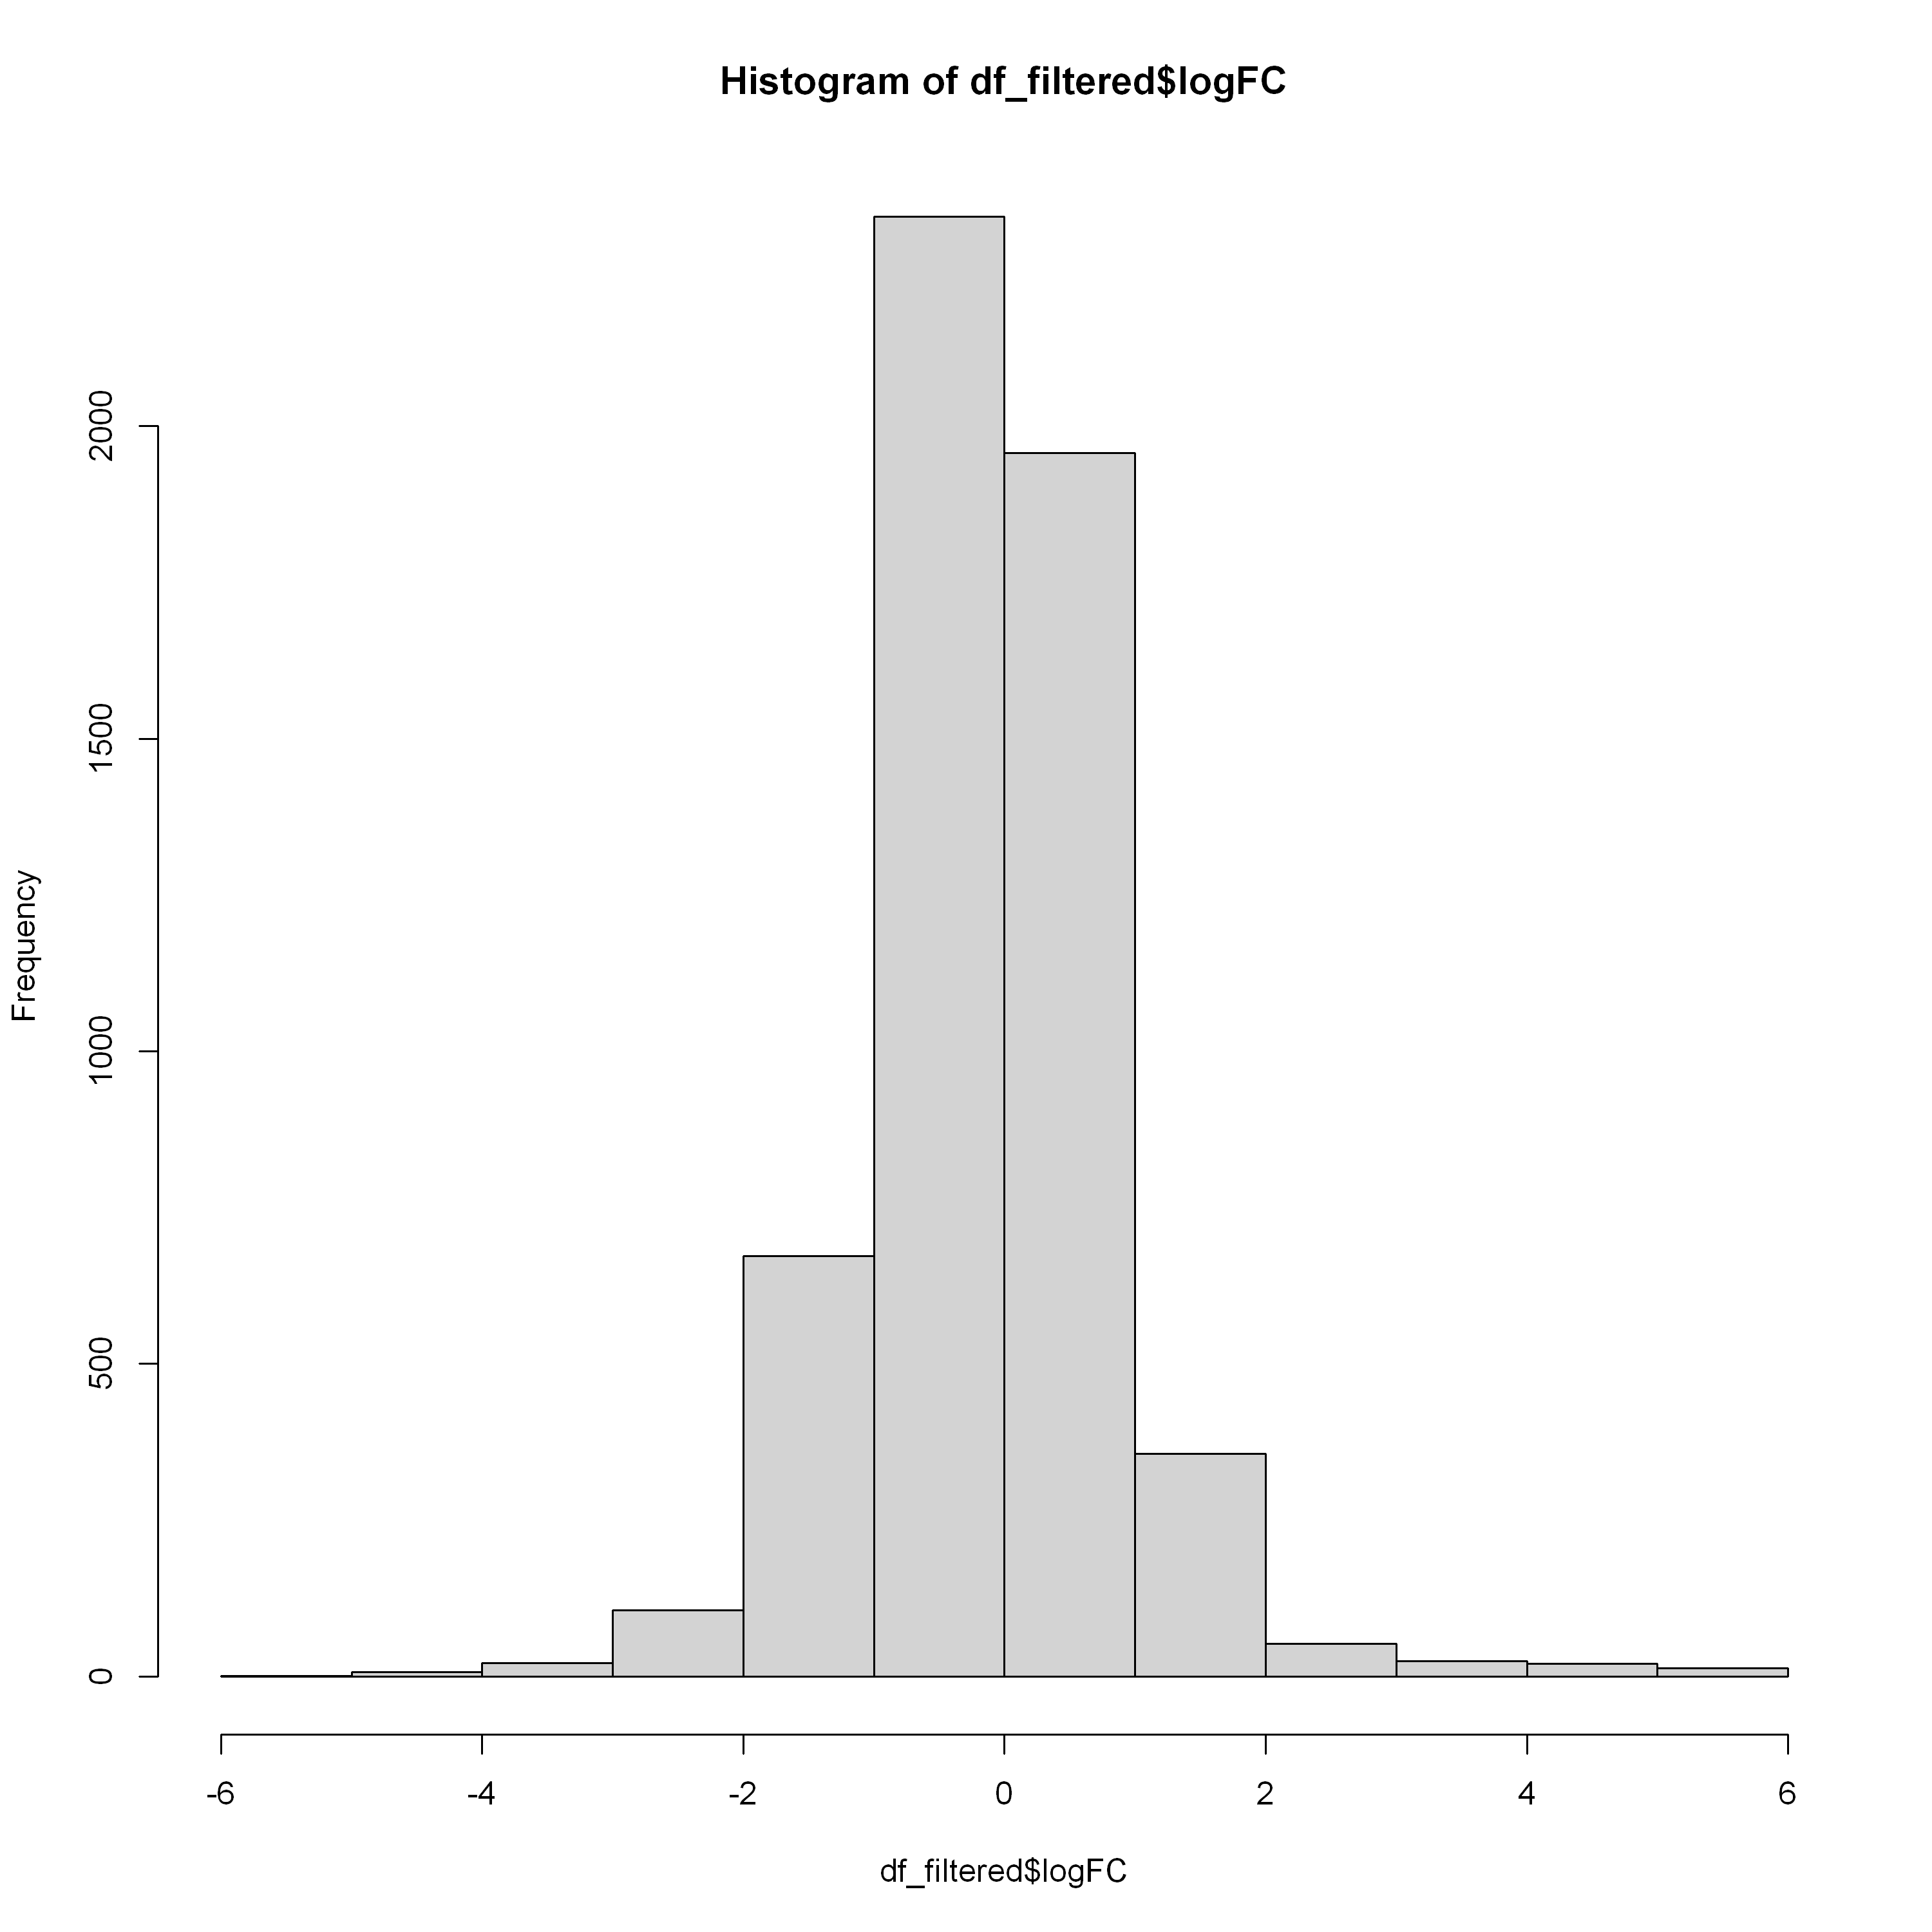

In [267]:
hist(df_filtered$logFC)

In [268]:
goseq_pal_fc_fun = colorRamp2(c(-5,-2,-1.5,-1, 0, 1,1.5, 2, 5), rev(RColorBrewer::brewer.pal(9, "RdBu")))
pfcgoseq = goseq_pal_fc_fun(seq(-10, 10, length.out = 20))
#pfcgoseq = goseq_pal_up_fun(c(-5, -2, 0, 2, 5))
#show_col(pfcgoseq)

In [269]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)

# Heatmap per Module

In [270]:
genome = 'MED4'

In [271]:
# pathwaylist = hpath_df %>% 
#     filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
#     distinct(gene_id, gene, pathway) %>%
#     add_count(pathway) %>%
#     filter((n >= 20) | (pathway %in% toppaths$pathway)) %>% distinct(pathway)

gene_meta = df_filtered %>% 
    distinct(gene_id,  Module) %>%
    #mutate(value_col = 'Yes') %>%
    #pivot_wider(id_cols=c('gene_id', 'gene'), names_from = 'Module1', values_from = 'value_col', values_fill = 'No') %>%
    column_to_rownames('gene_id') 
#gene_meta_matrix = gene_meta %>% select(!gene) %>%
#    select(pathwaylist$pathway) %>% 
#as.matrix()
head(gene_meta)

,Module
,<fct>
TX50_RS00020,Genetic information (18%)
TX50_RS00025,Function Unknown (39%)
TX50_RS00030,Genetic information (18%)
TX50_RS00035,Amino acid (7%)
TX50_RS00040,Genetic information (18%)
TX50_RS00045,Other (15%)


In [272]:
levels(gene_meta$Module1)

NULL

In [273]:
brewer.pal(n = 7, name = 'Set3')

[1] "#8DD3C7" "#FFFFB3" "#BEBADA" "#FB8072" "#80B1D3" "#FDB462" "#B3DE69"

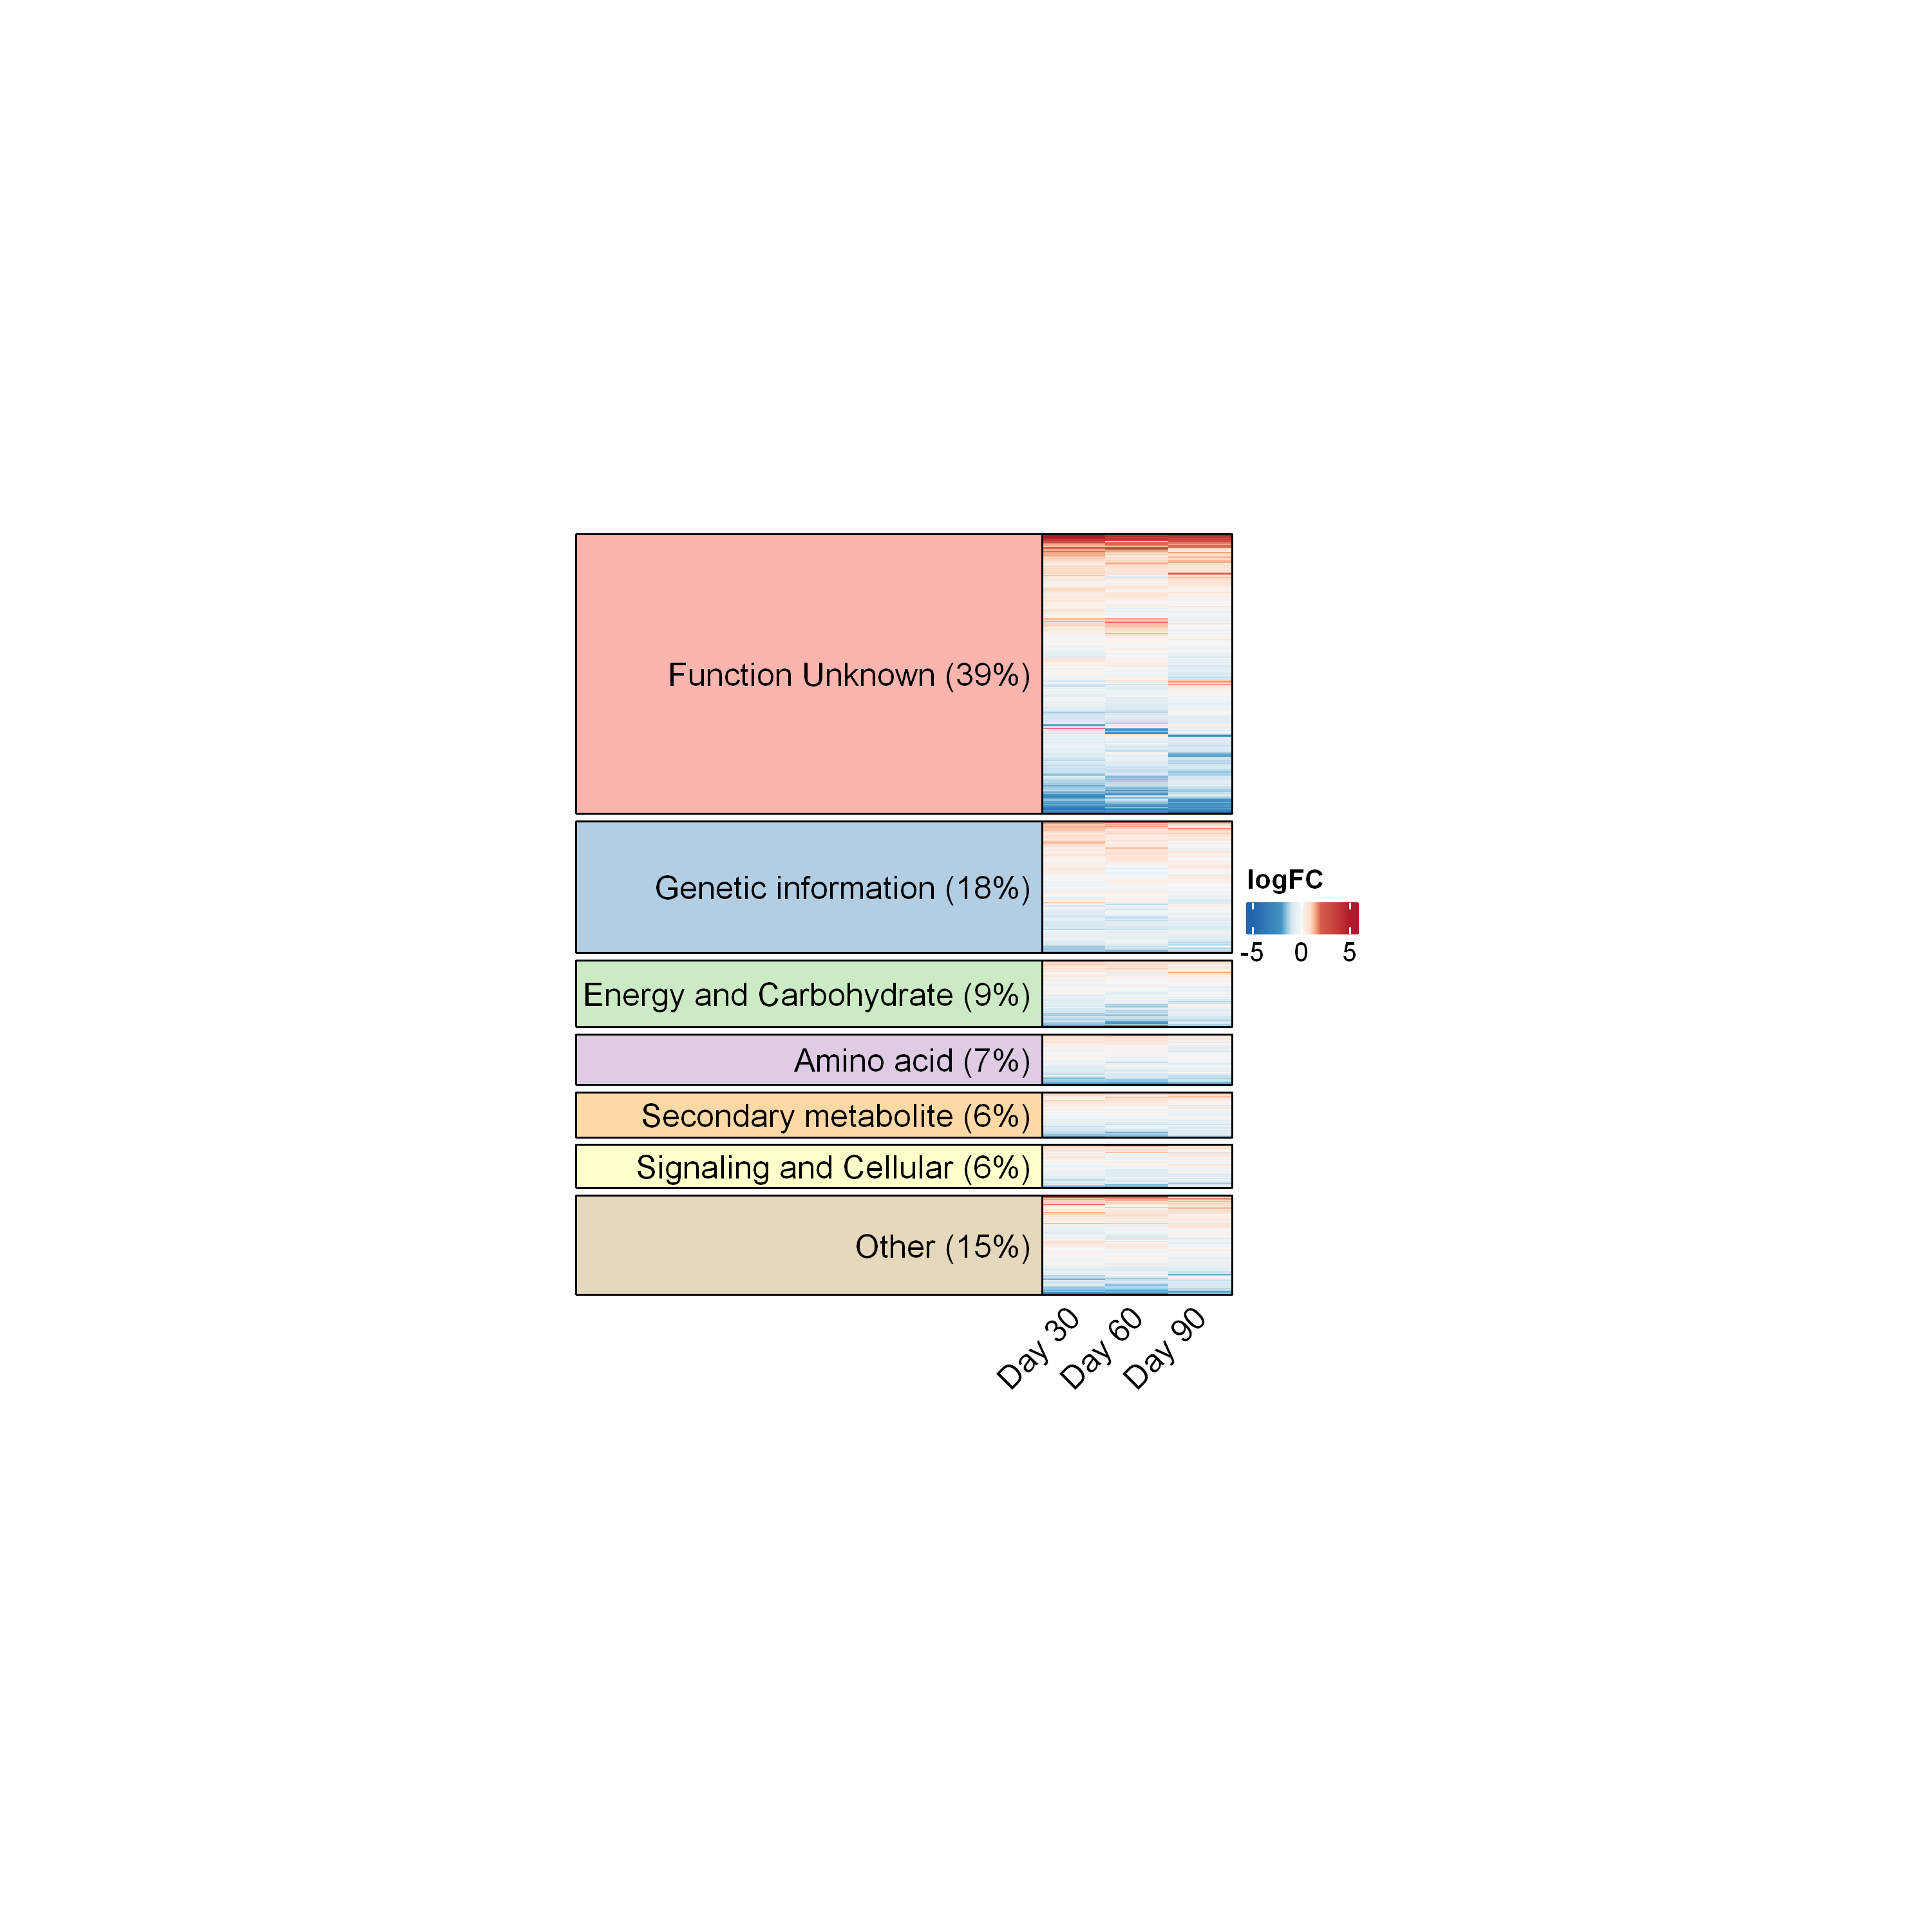

In [275]:
# toppaths = goseq_res %>% 
#     filter(module %in% module_name, 
#            padj < 0.05) %>% 
#     distinct(pathway)



ht_opt$TITLE_PADDING = unit(c(4, 4), "points")
gene_mat = df_filtered %>% #filter(gene_id %in% degenes$gene_id) %>% 
    pivot_wider(id_cols = Day, values_from = logFC, names_from = gene_id) %>% 
    #mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(Day) %>%
    column_to_rownames('Day')  %>%
    relocate(rownames(gene_meta)) %>% 
    as.matrix() %>% t() %>%
Heatmap(
     name = 'logFC',
    col = goseq_pal_fc_fun,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_columns  = FALSE,
     show_row_dend = FALSE,
#     row_order = rownames(goseq_meta),
#     row_split = goseq_meta$Group,
    
#     #row_title_gp = gpar(col = group_pal),
#     row_names_gp = gpar(col = group_pal),
#     column_names_gp = gpar(fontsize = 5),    
     border=TRUE,
     width=unit(2.5, 'cm'),
     height=unit(10, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
#     row_title=NULL,
     column_title=NULL,
    row_split = gene_meta$Module,
    show_row_names = FALSE,
    row_title_rot = 0,
    cluster_row_slices = FALSE, 
    column_names_rot = 45,
    row_title_gp = gpar(fill = brewer.pal(n = 7, name = 'Pastel1') #, font = 1:7 # levels(gene_meta$Module1)
                          ),
#    column_labels=gene_meta$gene,
    
#     top_annotation = HeatmapAnnotation(
#         Pathway=gene_meta_matrix, 
#         show_legend =FALSE,
#         col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
#         #show_legend=FALSE,
#     ),
    
#     cell_fun = function(j, i, x, y, width, height, fill) {
#         grid.text(sprintf("%s", gene_stars[i, j]), x, y, gp = gpar(fontsize = 9))
#     },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
ht_list = gene_mat #+ up_mat + down_mat #+ ann_mat
draw(ht_list) #, heatmap_legend_side = "bottom", merge_legend = TRUE) #,#column_title = module_title )

In [129]:
sessionInfo()

R version 4.2.0 (2022-04-22 ucrt)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 19044)

Matrix products: default

locale:
[1] LC_COLLATE=English_Israel.utf8  LC_CTYPE=English_Israel.utf8   
[3] LC_MONETARY=English_Israel.utf8 LC_NUMERIC=C                   
[5] LC_TIME=English_Israel.utf8    

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ComplexHeatmap_2.14.0       ggrepel_0.9.1              
 [3] ComplexUpset_1.3.3          circlize_0.4.15            
 [5] corrplot_0.92               pheatmap_1.0.12            
 [7] lubridate_1.9.2             forcats_1.0.0              
 [9] stringr_1.5.0               dplyr_1.1.0                
[11] purrr_1.0.1                 readr_2.1.4                
[13] tidyr_1.3.0                 tibble_3.1.8               
[15] tidyverse_2.0.0             readxl_1.4.2               
[17] goseq_1.50.0                gen